In [1]:
%config Completer.use_jedi = False
# !jupyter nbextension enable varInspector/main

In [2]:
import numpy as np
import pandas as pd
import dataframe_image as dfi

from utils import load_revisions

from scipy.stats import mannwhitneyu, ttest_ind, stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

-----------

## Overview

In [3]:
revisions = pd.read_csv("../data/revisions.txt", index_col=0)

In [4]:
mean_countsGenders = revisions.groupby("gender").agg({"length":"mean",
                                 "posWords":"mean",
                                 "negWords":"mean",
                                 "meanAbstractLevel":"mean"})
mean_countsGenders

,length,posWords,negWords,meanAbstractLevel
gender,,,,
f,2593.811981,311.850074,105.669788,3.676089
m,4451.313738,537.293602,180.936876,3.742337


**Mean values of the number of words, the number of positive, the number of negative words, and the mean abstratcion level for biographies related to females are all less than the corresponded mean values for biographies that refer to males. In section [X] we focus on mean abstraction level and investigate if this difference is significant or not.**

In [5]:
mean_countsCategories = revisions.groupby("role").agg({"length":"mean",
                                 "posWords":"mean",
                                 "negWords":"mean",
                                 "meanAbstractLevel":"mean"})
mean_countsCategories

,length,posWords,negWords,meanAbstractLevel
role,,,,
athlete,707.302921,89.695873,19.491673,3.788462
politician,4773.913953,607.352842,200.539021,3.762077
scientist,2872.680475,306.691048,110.211393,3.651864


**Mean values of the number of words, the number of positive, the number of negative words, and the mean abstratcion level for biographies distinguished by the role of each person. We see that there are differences on mean abstraction level across categories. In section [X] we investigate if these differences are significant with a confidence level of 95%.**

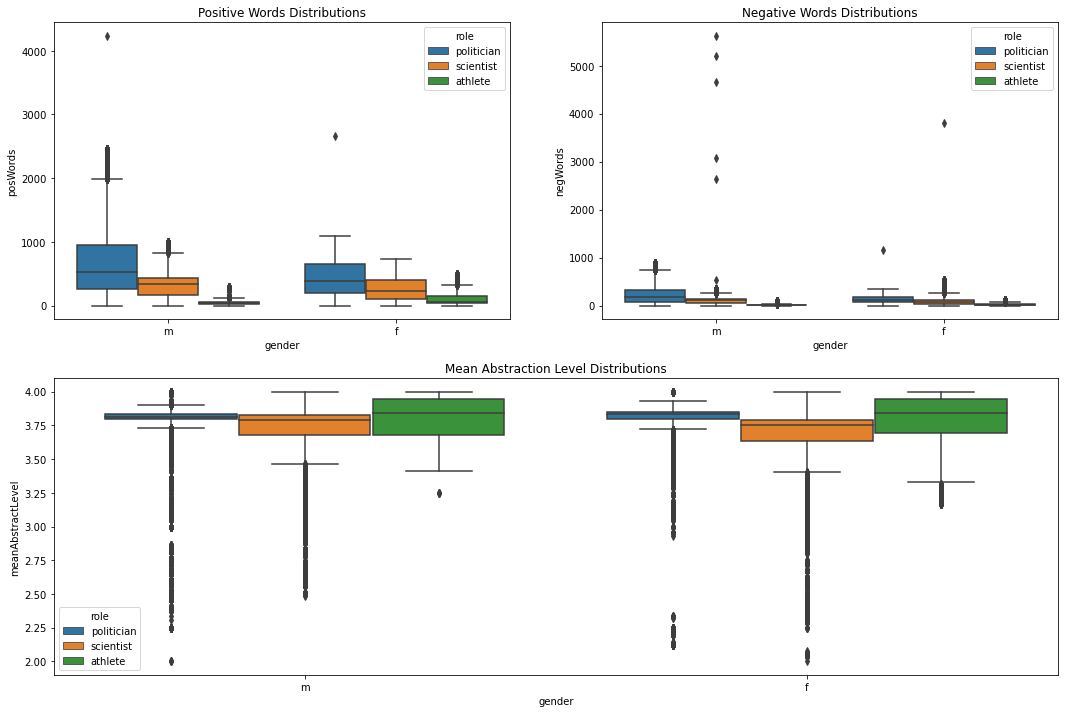

In [6]:
fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(221)
ax1 = fig.add_subplot(222)
ax2 = fig.add_subplot(212)

sns.boxplot(data=revisions, y="posWords", x="gender", hue="role", ax=ax)
sns.boxplot(data=revisions, y="negWords", x="gender", hue="role", ax=ax1)
sns.boxplot(data=revisions, y="meanAbstractLevel", x="gender", hue="role", ax=ax2)

ax.set_title("Positive Words Distributions")
ax1.set_title("Negative Words Distributions")
ax2.set_title("Mean Abstraction Level Distributions")
# plt.savefig("../images/distributions.pdf", bbox_inches='tight')
plt.show();

----------

## Revisions With no Null Values

In [13]:
revisionsWithoutNullValues = revisions.copy().dropna()
revisionsWithoutNullValues.reset_index(drop=True, inplace=True)
revisionsWithoutNullValues["meanSubjectivityRatio"] = (revisionsWithoutNullValues.posWords+revisionsWithoutNullValues.negWords)/revisionsWithoutNullValues.length
# revisionsWithoutNullValues.head()

In [14]:
index = revisionsWithoutNullValues["name"].value_counts().index

tmp_df = pd.DataFrame(columns=["name", "variance", "gender"])
for i in range(len(index)):
    name = index[i]
    gender = revisionsWithoutNullValues\
            .loc[revisionsWithoutNullValues["name"] == name]\
            .iloc[0]["gender"]
    rev0 = revisionsWithoutNullValues\
            .loc[revisionsWithoutNullValues["name"] == name]\
            .iloc[0]["meanAbstractLevel"]
    rev1 = revisionsWithoutNullValues\
            .loc[revisionsWithoutNullValues["name"] == name]\
            .iloc[-1]["meanAbstractLevel"]
    diff = rev1 - rev0
    tmp_df.loc[i] = [name, diff, gender]

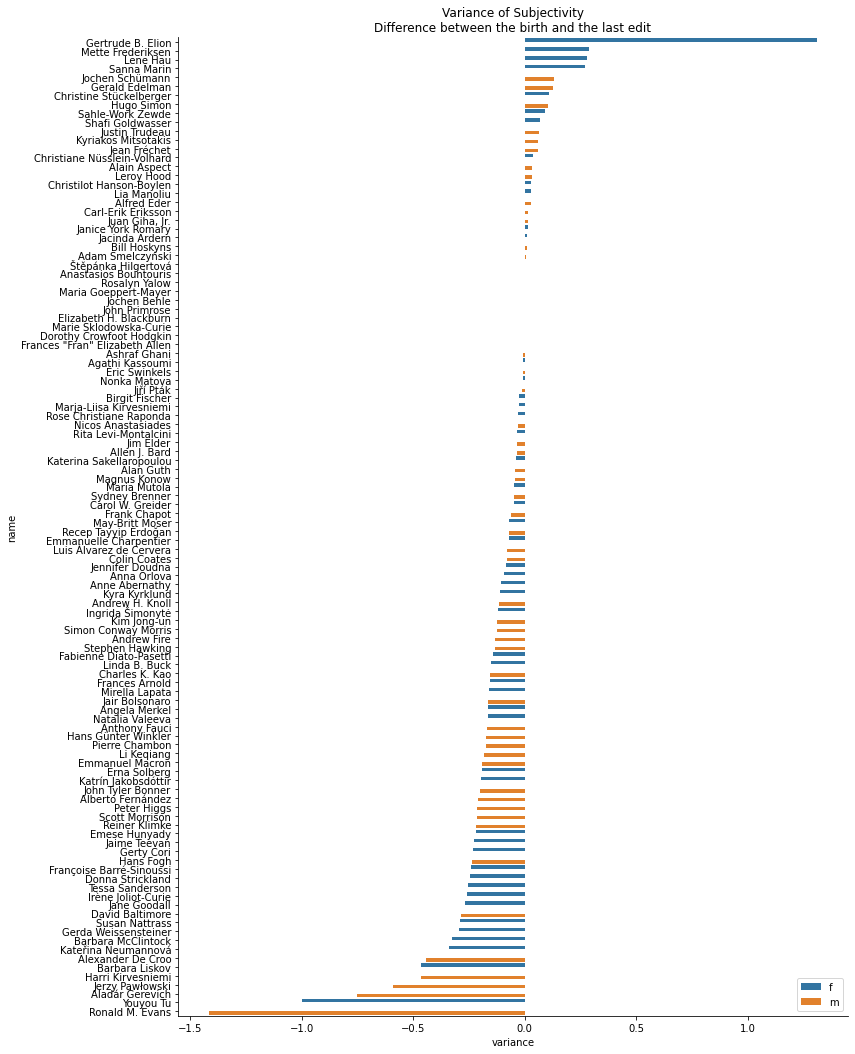

In [15]:
fig = plt.figure(figsize=(12,18))
ax = fig.add_subplot(111)

sns.barplot(data=tmp_df.sort_values(by="variance", ascending=False), y="name", 
            x="variance", hue="gender", 
            ax=ax, orient="h")

ax.spines["top"].set_color("None")
ax.spines["right"].set_color("None")

plt.legend(loc=4)
plt.title("Variance of Subjectivity\nDifference between the birth and the last edit")
# plt.savefig("../images/varianceOfSubjectivity.pdf", bbox_inches="tight")
plt.show();

In [16]:
revisionsWithoutNullValues_females = revisionsWithoutNullValues.loc[revisionsWithoutNullValues["gender"]=="f"]
revisionsWithoutNullValues_males = revisionsWithoutNullValues.loc[revisionsWithoutNullValues["gender"]=="m"]

females = revisionsWithoutNullValues_females.groupby("name").agg({"length":"mean",
                                 "posWords":"mean",
                                 "negWords":"mean",
                                 "meanAbstractLevel":"mean",
                                 "meanSubjectivityRatio": "mean"})
males = revisionsWithoutNullValues_males.groupby("name").agg({"length":"mean",
                                 "posWords":"mean",
                                 "negWords":"mean",
                                 "meanAbstractLevel":"mean",
                                 "meanSubjectivityRatio": "mean"})

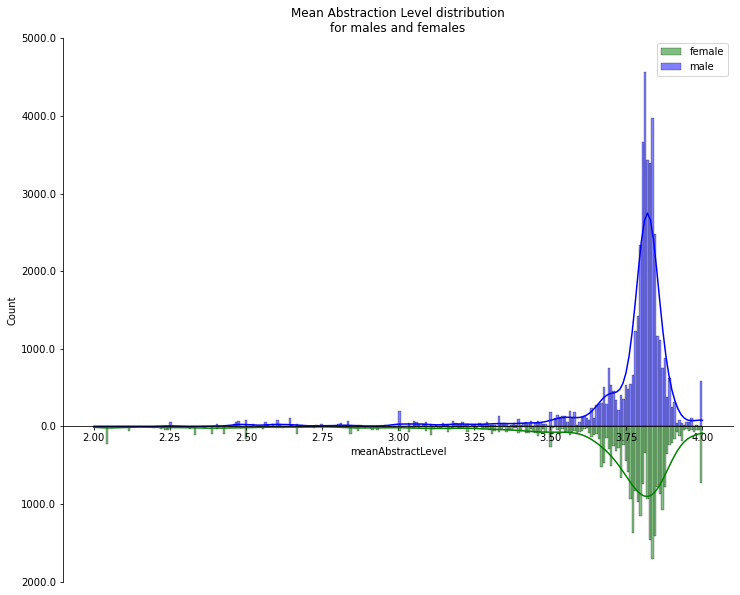

In [17]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.histplot(revisionsWithoutNullValues_females["meanAbstractLevel"], 
             kde=True, stat="count", bins=250,
             color='green', label="female")
for p in ax.patches:  # turn the histogram upside down
    p.set_height(-p.get_height())
for l in ax.lines:  # turn the kde curve upside down
    l.set_ydata(-l.get_ydata())

sns.histplot(revisionsWithoutNullValues_males["meanAbstractLevel"],
             kde=True, stat="count", bins=250,
             color='blue', label="male")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

pos_ticks = np.array([t for t in ax.get_yticks() if t > 0])
ticks = np.concatenate([-pos_ticks[::-1], [0], pos_ticks])
ax.set_yticks(ticks)
ax.set_yticklabels([f'{abs(t)}' for t in ticks])
ax.set_ylim(ymin=-2000, ymax=5000)
ax.spines['bottom'].set_position('zero')

plt.legend()
plt.title("Mean Abstraction Level distribution\nfor males and females")
# plt.savefig("../images/meanAbstractionLevelDistribution.pdf", bbox_inches='tight')
plt.show();

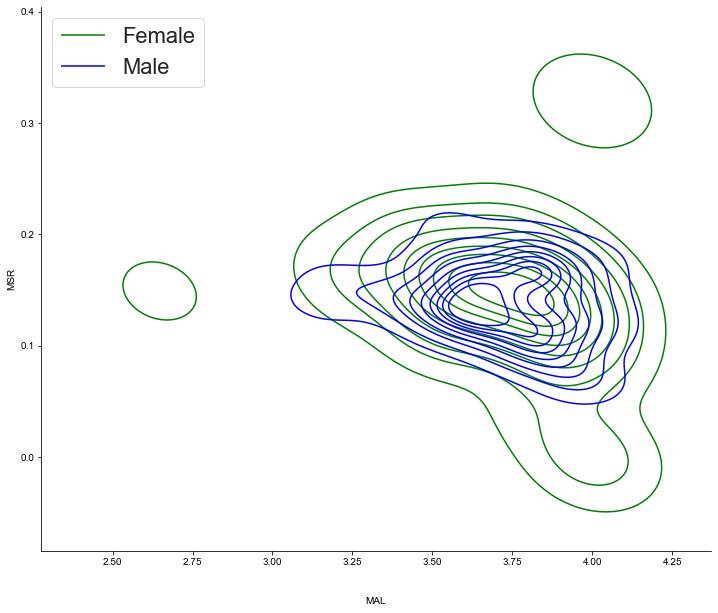

In [18]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.kdeplot(x=females["meanAbstractLevel"], y=females["meanSubjectivityRatio"],
             color='green', label="Female")
sns.kdeplot(x=males["meanAbstractLevel"], y=males["meanSubjectivityRatio"],
             color='blue', label="Male")

sns.set(font_scale=2)
sns.set_style("white")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend(loc="upper left")
ax.set_xlabel("MAL", labelpad=30)
ax.set_ylabel("MSR")
# plt.savefig("../images/msr-kde.pdf", bbox_inches='tight')
plt.show();

In [19]:
revisionsWithoutNullValues.groupby("role").agg({"length":"mean",
                                 "posWords":"mean",
                                 "negWords":"mean",
                                 "meanAbstractLevel":"mean"})

,length,posWords,negWords,meanAbstractLevel
role,,,,
athlete,709.170136,89.934656,19.543320,3.788462
politician,4781.150856,608.380122,200.873562,3.762077
scientist,2885.253398,308.278454,110.628857,3.651864


## Hypothesis Tests
### Mann-Whitney-Wilcoxon Tests for two independent samples

**RQ1**: Is the difference between the average values for mean abstraction level across genders significant? -> Is there evidence of linguistic biases across genders?

**RQ2**: Is there evidence that the average change of mean abstraction level on the beginning and on the end of each biography is greater for males rather than females?

### Kruskal-Wallis Test
**RQ3**: Is the difference between the mean values of mean abstraction level across categories significant? Meaning that there is evidence of linguistic biases based on the role of the person we investigate?

-------

#### RQ1

In [24]:
alpha = 0.05

statistic, p_value = mannwhitneyu(revisionsWithoutNullValues_females["meanAbstractLevel"].values,
                                  revisionsWithoutNullValues_males["meanAbstractLevel"].values,
                                  alternative="less")

if p_value < alpha:
    print(f"Reject null hypothesis with a p-value of {p_value:.5f}. \
Mean value of mean abstraction level for males is greater than mean value for females. F-statistic: {statistic:.2f}")
else:
    print(f"We can't reject the null hypothesis. p-value: {p_value:.5f}, \
confidence level: {(1-alpha)*100}%, F-statistic: {statistic:.2f}")

Reject null hypothesis with a p-value of 0.00000. Mean value of mean abstraction level for males is greater than mean value for females. F-statistic: 582014094.00


#### RQ2

In [25]:
tmp_df.groupby("gender").agg({"variance":"mean"})

,variance
gender,
f,-0.076799
m,-0.131384


In [26]:
tmp_males = tmp_df.loc[tmp_df["gender"]=="m"]
tmp_females = tmp_df.loc[tmp_df["gender"]=="f"]

In [27]:
alpha = 0.05

statistic, p_value = mannwhitneyu(tmp_females["variance"].values,
                                  tmp_males["variance"].values,
                                  alternative="two-sided")

if p_value < alpha:
    print(f"Reject null hypothesis with a p-value of {p_value:.2f}. \
Mean value of the changes on mean abstraction level at the beginning and at the end of each biography for males is")
else:
    print(f"We can't reject the null hypothesis. p-value: {p_value:.5f}, \
confidence level: {(1-alpha)*100}%, F-statistic: {statistic:.2f}")

We can't reject the null hypothesis. p-value: 0.91897, confidence level: 95.0%, F-statistic: 1528.00


#### RQ3

The dataset doesn't met the assumptions for ANOVA.
- Homogeneity of Variance
- Normality

Thus we go for **Kruskal-Wallis Test**

### ANOVA Assumption: Equal Variances

We observe below that boxplots don't have the same length. That means that variances aren't equal.

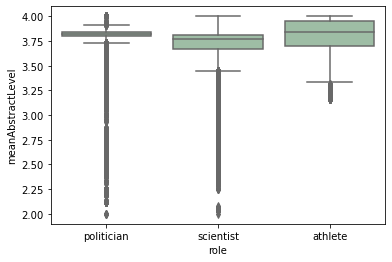

In [19]:
ax = sns.boxplot(x='role', y='meanAbstractLevel', data=revisionsWithoutNullValues, color='#99c2a2')
# ax = sns.swarmplot(x="role", y="meanAbstractLevel", data=revisionsWithoutNullValues, color='#7d0013')
plt.show()

In [20]:
import scipy.stats as stats

fvalue, pvalue = stats.f_oneway(revisionsWithoutNullValues["meanAbstractLevel"].loc[revisionsWithoutNullValues["role"]=="athlete"],
                                revisionsWithoutNullValues["meanAbstractLevel"].loc[revisionsWithoutNullValues["role"]=="politician"],
                                revisionsWithoutNullValues["meanAbstractLevel"].loc[revisionsWithoutNullValues["role"]=="scientist"])
print(fvalue, pvalue)

1460.8062520038097 0.0


In [21]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [22]:
# Ordinary Least Squares (OLS) model
model = ols('meanAbstractLevel ~ C(role)', data=revisionsWithoutNullValues).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(role),230.892861,2.0,1460.806252,0.0
Residual,5815.999995,73593.0,NaN,NaN


In [23]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=revisionsWithoutNullValues["meanAbstractLevel"],
                          groups=revisionsWithoutNullValues["role"], alpha=0.05)
print(tukey)

    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1     group2   meandiff p-adj  lower   upper  reject
-----------------------------------------------------------
   athlete politician  -0.0264 0.001 -0.0372 -0.0156   True
   athlete  scientist  -0.1366 0.001 -0.1475 -0.1257   True
politician  scientist  -0.1102 0.001 -0.1152 -0.1052   True
-----------------------------------------------------------


In [24]:
from bioinfokit.analys import stat

res = stat()
res.tukey_hsd(df=revisionsWithoutNullValues, res_var="meanAbstractLevel",
              xfac_var="role", anova_model='meanAbstractLevel ~ C(role)')
res.tukey_summary

C:\Users\eLab\anaconda3\envs\wikipedia\lib\site-packages\bioinfokit\analys.py:365: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]


,group1,group2,Diff,Lower,Upper,q-value,p-value
0,politician,scientist,0.110213,0.105185,0.115241,72.652485,0.001
1,politician,athlete,0.026385,0.015598,0.037173,8.107372,0.001
2,scientist,athlete,0.136599,0.125688,0.147509,41.497131,0.001


#### Distributions of Residuals

C:\Users\eLab\anaconda3\envs\wikipedia\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


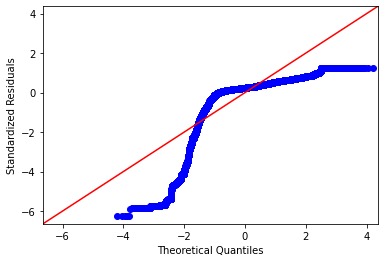

In [25]:
# res.anova_std_residuals are standardized residuals obtained from ANOVA (check above)
sm.qqplot(res.anova_std_residuals, line='45')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.show()

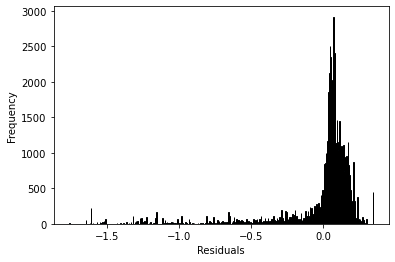

In [26]:
# histogram
plt.hist(res.anova_model_out.resid, bins='auto', histtype='bar', ec='k') 
plt.xlabel("Residuals")
plt.ylabel('Frequency')
plt.show()

**QQ-plot and histogram of residuals suggest that the residuals are not normally distributed. Thus we are going to use Levene's Test for Homogeneity of Variances**

#### Homogeneity of Variances

In [27]:
res.levene(df=revisionsWithoutNullValues, res_var="meanAbstractLevel",
              xfac_var="role")
res.levene_summary

,Parameter,Value
0,Test statistics (W),862.5801
1,Degrees of freedom (Df),2.0000
2,p value,0.0000


**As p-value is equal to 0 we can reject the null hypothesis and support that variances are not equal.**